# Necessary libraries

In [1]:
# Import necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve, f1_score, accuracy_score, roc_curve, auc
from sklearn.linear_model import LogisticRegression
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
import keras_tuner as kt
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import pickle
import random

# Set random seeds for full reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

## Exploratory Data Analysis for Diabetes Prediction Dataset
In this section, we analyse the dataset,by visualising it to gather insights to take action in the next stage.

In [2]:
## Load & Inspect the Dataset
## We first load the dataset and preview the first few rows to understand its structure.

# Load the dataset
file_path = "diabetes_prediction_dataset.csv"  
df = pd.read_csv(file_path)

# Display first few rows
print("Dataset Preview:")
print(df.head())

# Check dataset shape
print("\nDataset Shape:", df.shape)

Dataset Preview:
   gender   age  hypertension  heart_disease smoking_history    bmi  \
0  Female  80.0             0              1           never  25.19   
1  Female  54.0             0              0         No Info  27.32   
2    Male  28.0             0              0           never  27.32   
3  Female  36.0             0              0         current  23.45   
4    Male  76.0             1              1         current  20.14   

   HbA1c_level  blood_glucose_level  diabetes  
0          6.6                  140         0  
1          6.6                   80         0  
2          5.7                  158         0  
3          5.0                  155         0  
4          4.8                  155         0  

Dataset Shape: (100000, 9)


In [3]:
## Checking for Missing Values & Class Imbalance
## We check for missing values and confirm whether the dataset is imbalanced.

# Check for missing values
print("Missing Values per Column:\n", df.isnull().sum())

# Check class distribution (percentage of diabetic vs. non-diabetic)
print("\nClass Distribution (%):")
print(df["diabetes"].value_counts(normalize=True) * 100)


Missing Values per Column:
 gender                 0
age                    0
hypertension           0
heart_disease          0
smoking_history        0
bmi                    0
HbA1c_level            0
blood_glucose_level    0
diabetes               0
dtype: int64

Class Distribution (%):
diabetes
0    91.5
1     8.5
Name: proportion, dtype: float64


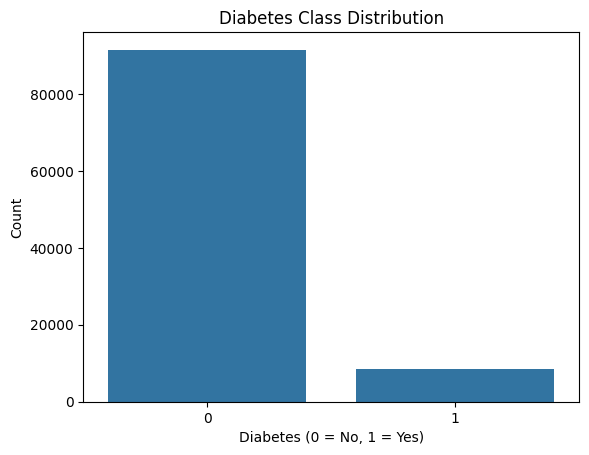

In [4]:
## Visualizing Class Imbalance
## A countplot is used to show how many cases belong to each class (diabetic vs. non-diabetic).

# Plot class distribution
sns.countplot(x=df["diabetes"])
plt.title("Diabetes Class Distribution")
plt.xlabel("Diabetes (0 = No, 1 = Yes)")
plt.ylabel("Count")
plt.show()


In [5]:
## Understanding Data Types
## We check the data types to determine which features are categorical, numerical, and binary.
## This helps in deciding which preprocessing steps to apply

# Display dataset info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 9 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   gender               100000 non-null  object 
 1   age                  100000 non-null  float64
 2   hypertension         100000 non-null  int64  
 3   heart_disease        100000 non-null  int64  
 4   smoking_history      100000 non-null  object 
 5   bmi                  100000 non-null  float64
 6   HbA1c_level          100000 non-null  float64
 7   blood_glucose_level  100000 non-null  int64  
 8   diabetes             100000 non-null  int64  
dtypes: float64(3), int64(4), object(2)
memory usage: 6.9+ MB


In [6]:
## Checking Unique Values
## This helps us understand the diversity of values in each feature.
## Categorical features with multiple unique values will require encoding.

# Check the number of unique values in each column
for col in df.columns:
    print(f"Feature '{col}' has {df[col].nunique()} unique values: {df[col].unique()[:10]}")


Feature 'gender' has 3 unique values: ['Female' 'Male' 'Other']
Feature 'age' has 102 unique values: [80. 54. 28. 36. 76. 20. 44. 79. 42. 32.]
Feature 'hypertension' has 2 unique values: [0 1]
Feature 'heart_disease' has 2 unique values: [1 0]
Feature 'smoking_history' has 6 unique values: ['never' 'No Info' 'current' 'former' 'ever' 'not current']
Feature 'bmi' has 4247 unique values: [25.19 27.32 23.45 20.14 19.31 23.86 33.64 54.7  36.05 25.69]
Feature 'HbA1c_level' has 18 unique values: [6.6 5.7 5.  4.8 6.5 6.1 6.  5.8 3.5 6.2]
Feature 'blood_glucose_level' has 18 unique values: [140  80 158 155  85 200 145 100 130 160]
Feature 'diabetes' has 2 unique values: [0 1]


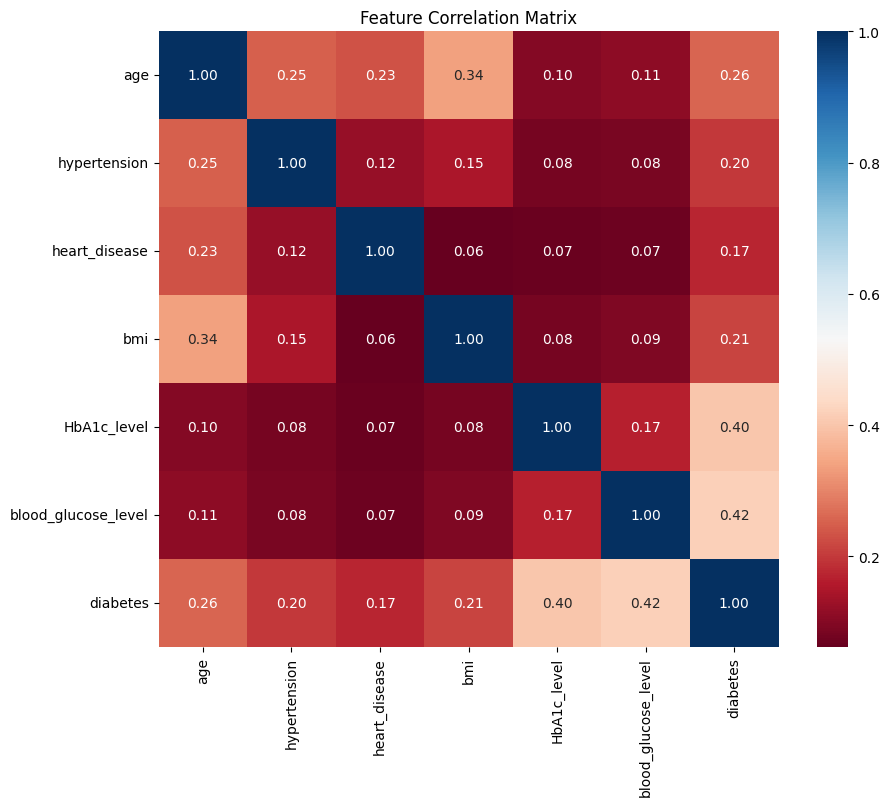

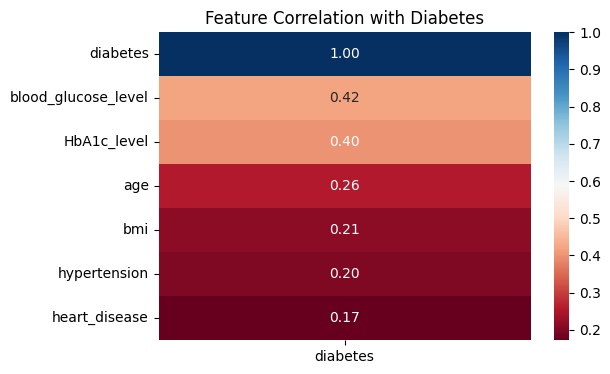

In [7]:
## Feature Correlation Analysis
## We calculate the correlation between features and the target variable (diabetes).
## Features with high correlation may be strong predictors, while low-correlation features may be less useful.

# Copy dataset & drop categorical variables for correlation analysis
n_df = df.copy()
n_df = n_df.drop(columns=['smoking_history', 'gender'])

# Compute correlation matrix
correlation_matrix = n_df.corr()

# Visualize correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', fmt='.2f')
plt.title("Feature Correlation Matrix")
plt.show()

# Check correlation with diabetes specifically
target_corr = correlation_matrix['diabetes'].sort_values(ascending=False)

# Visualize correlation with diabetes
plt.figure(figsize=(6, 4))
sns.heatmap(target_corr.to_frame(), cmap="RdBu", annot=True, fmt='.2f')
plt.title('Feature Correlation with Diabetes')
plt.show()

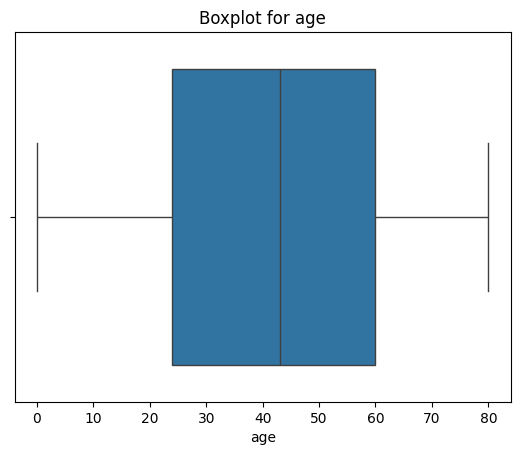

The approximate number of outliers for age is 0


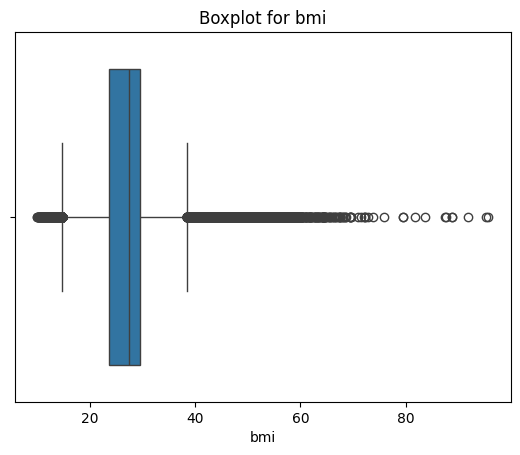

The approximate number of outliers for bmi is 7086


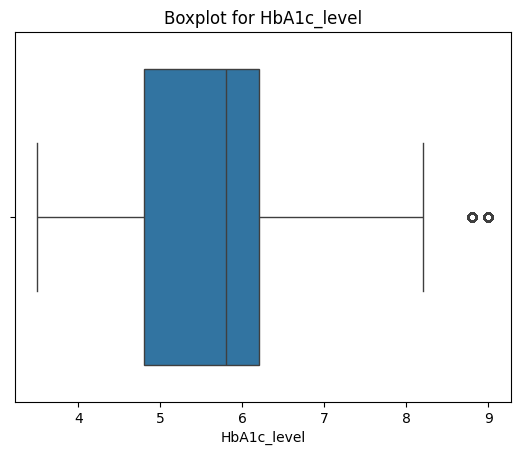

The approximate number of outliers for HbA1c_level is 1315


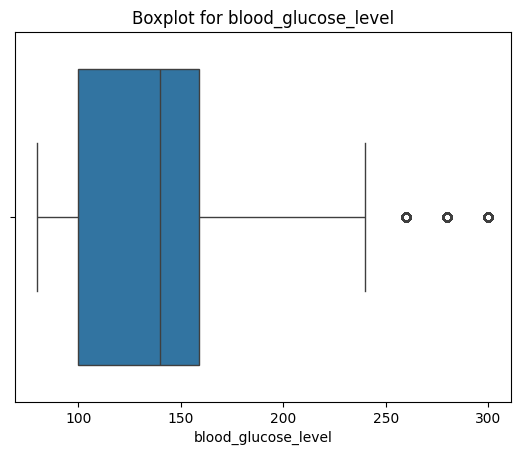

The approximate number of outliers for blood_glucose_level is 2038


In [8]:
## Outlier Detection
## We detect outliers using the IQR method. Boxplots visualize extreme values.
## Features with significant outliers (e.g., BMI, blood glucose level) may need winsorization or robust scaling.

# Define the outlier detection function
def outlier_one_feature(df, x, thresh_val=1.5):
    """
    Identifies and visualizes outliers using the IQR method.
    
    df: DataFrame.
    x: Feature to analyze.
    thresh_val: Outlier threshold (default = 1.5).
    """
    q1 = df[x].quantile(0.25)
    q3 = df[x].quantile(0.75)
    iqr = q3 - q1

    max_limit = q3 + (thresh_val * iqr)
    min_limit = q1 - (thresh_val * iqr)

    # Count outliers
    outliers_high = df[df[x] >= max_limit]
    outliers_low = df[df[x] <= min_limit]
    num_outliers = outliers_high.shape[0] + outliers_low.shape[0]

    # Boxplot visualisation
    sns.boxplot(data=df, x=x, whis=thresh_val)
    plt.title(f'Boxplot for {x}')
    plt.show()

    print(f'The approximate number of outliers for {x} is {num_outliers}')

# Run outlier detection for key numerical features
for feature in ["age", "bmi", "HbA1c_level", "blood_glucose_level"]:
    outlier_one_feature(df, x=feature)

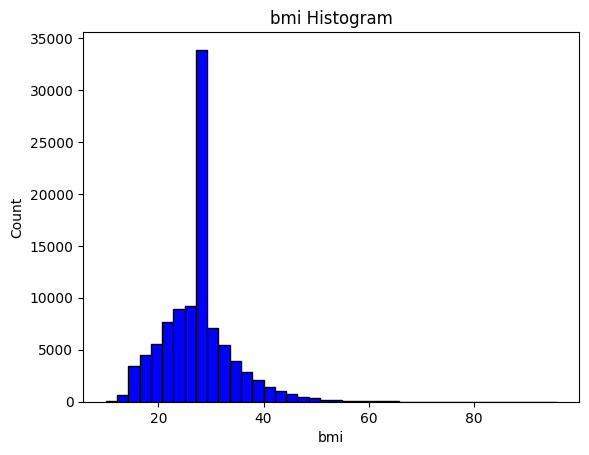

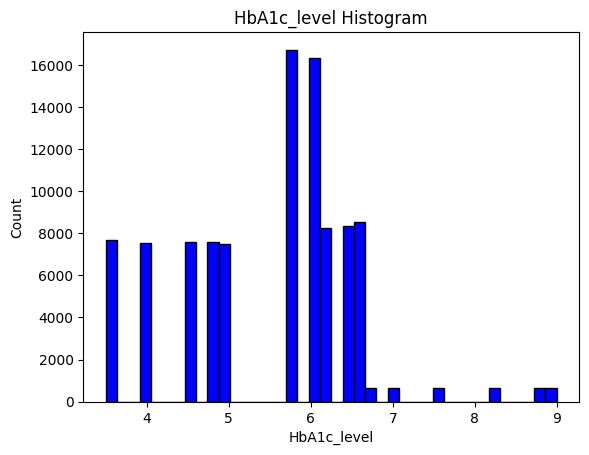

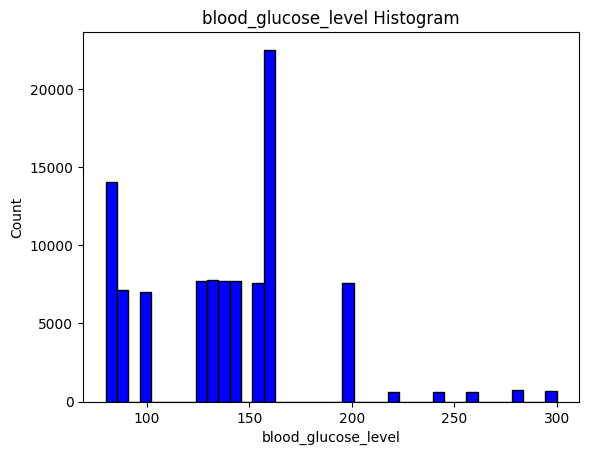

In [9]:
## Checking Feature Distributions
## We plot histograms to examine how features are distributed.
## Highly skewed features may require transformation.

# List of numerical features to check
numerical_features = ["bmi", "HbA1c_level", "blood_glucose_level"]

# Create histograms for each feature
for feature in numerical_features:
    plt.hist(df[feature], bins=40, color='blue', edgecolor='black')
    plt.title(f'{feature} Histogram')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.show()

## Preprocessing

Data Preprocessing & Feature Engineering
Before training the model, we need to clean and preprocess the dataset.  
Key preprocessing steps:
- Handling categorical variables: Encoding `gender` and `smoking_history`.  
- Addressing outliers: Applying capping (Winsorization) for `bmi`, `HbA1c_level`, and `blood_glucose_level`.  
- Feature scaling: Using `RobustScaler` to normalize numerical values while being robust to outliers.  
- Handling class imbalance using class weighting.
- Splitting dataset: `70% training`, `15% validation`, `15% test`.  

This ensures that our dataset is properly formatted before feeding it into the deep learning model.

In [10]:
## Cleaning Dataset 
# - We remove records where `gender == "Other"` because they are a small minority and may not contribute meaningfully to training.
# - This simplifies the dataset while keeping relevant data.

# Check initial dataset shape
print('The old shape is:', df.shape)

# Remove records where gender is "Other"
df = df.query('gender != "Other"')

# Check new dataset shape
print('The new shape is:', df.shape)


The old shape is: (100000, 9)
The new shape is: (99982, 9)


In [11]:
## Cleaning Categorical Features (Merging `smoking_history` Categories)
# We simplify `smoking_history` into three categories:
#  `never` - Never smoked.
#  `former` - Includes former smokers, unknown history, and similar categories.
#  `current` - Currently smoking.

# Merge similar smoking categories into three groups: never, current, former
df['smoking_history'] = df['smoking_history'].replace({
    'No Info': 'former',   # Merge "No Info" into "former"
    'ever': 'former',      # Merge "ever" into "former"
    'not current': 'former' # Merge "not current" into "former"
})

# Check final unique values
print("Final unique values in smoking_history:")

Final unique values in smoking_history:


In [12]:
## Handling Outliers Using Winsorisation
# Outliers can distort deep learning models, so we cap extreme values using IQR-based Winsorization:
# - `bmi` - Many extreme values; capping prevents unrealistic cases.
# - `HbA1c_level`- Some extreme values; capping ensures stable training.
# - `blood_glucose_level`- Outliers capped to maintain meaningful medical ranges.
# This prevents outliers from negatively affecting model performance.

# Define function to compute outlier limits using IQR
def compute_outlier_bounds(df, feature, thresh_val=1.5):
    """
    Computes the lower and upper bounds for outliers using the IQR method.
    
    Parameters:
    df (DataFrame): The dataset
    feature (str): The feature to analyze
    thresh_val (float): The threshold multiplier for defining outliers (default=1.5)
    
    Returns:
    min_value (float): The lower bound for outlier capping
    max_value (float): The upper bound for outlier capping
    """
    q1 = df[feature].quantile(0.25)
    q3 = df[feature].quantile(0.75)
    iqr = q3 - q1

    max_value = q3 + (thresh_val * iqr)
    min_value = q1 - (thresh_val * iqr)
    
    print(f"Computed outlier bounds for {feature}: Min = {min_value}, Max = {max_value}")
    return min_value, max_value

# Compute outlier bounds for each feature
bmi_min, bmi_max = compute_outlier_bounds(df, "bmi")
hba1c_min, hba1c_max = compute_outlier_bounds(df, "HbA1c_level")
glucose_min, glucose_max = compute_outlier_bounds(df, "blood_glucose_level")

# Define function for Winsorization using computed limits
def cap_outliers(df, feature, max_value, min_value):
    """
    Capping outliers by setting extreme values to the computed max and min values.
    
    Parameters:
    df (DataFrame): The dataset
    feature (str): The feature to modify
    max_value (float): The upper limit for the feature
    min_value (float): The lower limit for the feature
    
    Returns:
    df (DataFrame): Modified dataset with capped values
    """
    print(f"Capping outliers for {feature}...")
    
    df[feature] = np.where(df[feature] > max_value, max_value, df[feature])
    df[feature] = np.where(df[feature] < min_value, min_value, df[feature])
    
    return df

# Apply Winsorization using our computed limits
df = cap_outliers(df, "bmi", bmi_max, bmi_min)
df = cap_outliers(df, "HbA1c_level", hba1c_max, hba1c_min)
df = cap_outliers(df, "blood_glucose_level", glucose_max, glucose_min)

print("Outliers capped successfully using computed IQR limits!")

Computed outlier bounds for bmi: Min = 14.705, Max = 38.504999999999995
Computed outlier bounds for HbA1c_level: Min = 2.6999999999999993, Max = 8.3
Computed outlier bounds for blood_glucose_level: Min = 11.5, Max = 247.5
Capping outliers for bmi...
Capping outliers for HbA1c_level...
Capping outliers for blood_glucose_level...
Outliers capped successfully using computed IQR limits!


In [13]:
## Define Features (X) and Target (y)
# - `X` contains all independent variables (features).
# - `y` contains the target variable (`diabetes`), which the model will learn to predict.

# Define X (features) and y (target)
X = df.drop(columns=['diabetes'])
y = df['diabetes']

## Splitting the Data
#  We divide our dataset into three parts:
#  - Training Set (70%) - Used to train the model.
#  - Validation Set (15%) - Used to fine-tune model hyperparameters.
#  - Test Set (15%) - Used to evaluate final model performance.
#  - `stratify=y` ensures that each set keeps the same proportion of diabetic and non-diabetic cases.

# Split dataset into training (70%), validation (15%), and test (15%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

## Preprocessing Pipeline
#Instead of manually transforming features, we use a pipeline:
# - Scaling Numerical Features: Uses `RobustScaler()` to handle outliers.
# - Encoding Categorical Features: Uses `OneHotEncoder()` to convert categorical variables into numbers.

# Define preprocessing pipeline (Encoding & Scaling)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', RobustScaler(), ["age", "bmi", "HbA1c_level", "blood_glucose_level"]),  # Scale numerical features
        ('cat', OneHotEncoder(drop='first'), ["gender", "smoking_history"])  # Encode categorical features
    ]
)
# Create pipeline with preprocessing steps
pipeline = Pipeline(steps=[('preprocessor', preprocessor)])

# Apply the pipeline AFTER splitting 
X_train = pipeline.fit_transform(X_train)
X_val = pipeline.transform(X_val)
X_test = pipeline.transform(X_test)

# Confirm final dataset shapes
print("Final Transformed Dataset Shapes:")
print("Training Set:", X_train.shape)
print("Validation Set:", X_val.shape)
print("Test Set:", X_test.shape)

Final Transformed Dataset Shapes:
Training Set: (69987, 7)
Validation Set: (14997, 7)
Test Set: (14998, 7)


In [14]:
## Handling Class Imbalance
#Our dataset is "imbalanced" (91.5% non-diabetic, 8.5% diabetic).
# By using class weights:
# - The model will "pay more attention" to diabetic cases.
# - `compute_class_weight(class_weight='balanced')` assigns a higher weight to the minority class.

# Compute class weights
classes = np.unique(y_train)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train
)

# Convert to dictionary format
class_weights = dict(zip(classes, class_weights))

print("Final Class Weights:", class_weights)

Final Class Weights: {np.int64(0): np.float64(0.54645751674813), np.int64(1): np.float64(5.881260504201681)}


## Modeling

Building the Initial Neural Network

We start by creating a **simple baseline model** before tuning hyperparameters.  
Key architectural choices:
- **Dense layers with ReLU activation** for non-linearity.  
- **Batch Normalization** to stabilize training.  
- **Dropout layers** to prevent overfitting.  
- **Binary Cross-Entropy Loss** since this is a classification problem.  

We will first train this model and evaluate its performance before deciding on further improvements.

In [15]:
## We build a Sequential neural network for binary classification.
# Define the model architecture

model = Sequential([
    
    # Input layer: Accepts input features (same number as in X_train)
    Input(shape=(X_train.shape[1],)),
    
    # First hidden layer with 64 neurons, ReLU activation
    Dense(64, activation='relu'),  
    BatchNormalization(),  # Normalizes activations for stability
    Dropout(0.3),   # Prevents overfitting
    
    # Second hidden layer with 32 neurons, ReLU activation
    Dense(32, activation='relu'), 
    BatchNormalization(),
    Dropout(0.3),
    
    # Output layer with 1 neuron and sigmoid activation for binary classification
    Dense(1, activation='sigmoid') 
])

## Before training, we need to compile the model.
# We use the Adam optimizer to adjust the model’s parameters.
# Binary cross-entropy as the loss function since we are dealing with binary classification.
# Accuracy to track performance.

# Compile the model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',  # Since we're doing binary classification
    metrics=['accuracy']        # Track accuracy during training
)

# Display model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 64)             │           512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,009 (11.75 KB)

 Trainable params: 2,817 (11.00 KB)

 Non-trainable params: 192 (768.00 B)

In [16]:
## To prevent overfitting, we introduce early stopping. 
# This stops training if validation loss does not improve after five rounds and ensures we keep the best model.

# Define Early Stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,  # Stop if val_loss doesn’t improve for 5 epochs
    restore_best_weights=True  # Restore best weights after stopping
)

## Training the Model
# It will run for a maximum of 50 epochs, processing 32 samples at a time. 
# We apply class weights to handle imbalance and early stopping to stop unnecessary training.

# Train the model
history = model.fit(
    X_train, y_train, 
    validation_data=(X_val, y_val),
    epochs=50,  # Train for up to 50 epochs
    batch_size=32,  # Process 32 samples at a time
    class_weight=class_weights,  # Adjust training for class imbalance
    callbacks=[early_stopping],  # Apply early stopping
    verbose=1  # Show training progress
)

# Print final training results
print("Model training complete!")

Epoch 1/50
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 1s 417us/step - accuracy: 0.7712 - loss: 0.3952 - val_accuracy: 0.8802 - val_loss: 0.2333
Epoch 2/50
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 1s 390us/step - accuracy: 0.8663 - loss: 0.2764 - val_accuracy: 0.8870 - val_loss: 0.1995
Epoch 3/50
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 1s 424us/step - accuracy: 0.8669 - loss: 0.2499 - val_accuracy: 0.8852 - val_loss: 0.1886
Epoch 4/50
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 1s 439us/step - accuracy: 0.8676 - loss: 0.2419 - val_accuracy: 0.8944 - val_loss: 0.1817
Epoch 5/50
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 1s 430us/step - accuracy: 0.8739 - loss: 0.2331 - val_accuracy: 0.8911 - val_loss: 0.1867
Epoch 6/50
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 1s 422us/step - accuracy: 0.8765 - loss: 0.2270 - val_accuracy: 0.8936 - val_loss: 0.1855
Epoch 7/50
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 1s 418us/step - accuracy: 0.8774 - loss: 0.2247 - val_accuracy: 0.9041 - val_loss: 0.1709
Epoch 8/50
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 1s 401us/step - accuracy: 0.8784 -

In [17]:
## After training, we evaluate the model on the test dataset to measure final accuracy and loss. 
# This helps us understand how well the model generalizes to new data.

# Evaluate on Test Set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)

print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 244us/step - accuracy: 0.9120 - loss: 0.1621
Test Accuracy: 0.9124
Test Loss: 0.1621


In [18]:
## Hyperparameter Tuning with Keras Tuner
# To optimize the neural network, we use Keras Tuner to find the best:
# - Number of layers
# - Neurons per layer
# - Dropout rates
# - Learning rate
# We perform a random search across different architectures and select the best model based on validation loss.  
# Once the best hyperparameters are found, we retrain the model using these optimized settings.

def build_model(hp):
    """
    Function to define and tune the ANN model.
    Uses Keras Tuner to find the best hyperparameters.
    """

    model = Sequential()

    # Input Layer
    model.add(Input(shape=(X_train.shape[1],)))  

    # Number of Hidden Layers (1 to 3)
    num_hidden_layers = hp.Int('num_hidden_layers', min_value=1, max_value=3, step=1)

    prev_units = None  # Store previous layer units to follow decreasing pattern

    # Add Hidden Layers with Tuneable Units & Dropout
    for i in range(num_hidden_layers):
        max_units = max(prev_units - 16, 16) if prev_units else 64
        min_units = 16
        units = hp.Int(f'num_units_layer_{i+1}', min_value=min_units, max_value=max_units, step=16)

        model.add(Dense(units, activation='relu'))
        
        # Apply Batch Normalization for stability
        model.add(BatchNormalization())

        # Adding Dropout only if selected by the tuner
        use_dropout = hp.Boolean(f'use_dropout_layer_{i+1}')
        if use_dropout:
            dropout_rate = hp.Float(f'dropout_rate_layer_{i+1}', min_value=0.1, max_value=0.4, step=0.1)
            model.add(Dropout(dropout_rate))

        prev_units = units  # Update for next layer

    # Output Layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile Model
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=1e-5, max_value=1e-2, sampling='log')),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model


In [19]:
## Define and Run the Hyperparameter Tuner

# We use Keras Tuner's RandomSearch to test different architectures and configurations.
tuner = kt.RandomSearch(
    build_model,              # The model function
    objective='val_loss',      # Minimize validation loss
    max_trials=10,             # Try 10 different architectures
    executions_per_trial=1,    # Run each trial once
    directory='tuner_results', # Save tuning results in this folder
    project_name='diabetes',   # Subfolder name
    overwrite=True             # Overwrite previous tuning results
)

## Implement Early Stopping 

# Early stopping prevents overfitting by stopping training if the model stops improving.
early_stopping = EarlyStopping(
    monitor='val_loss', # Track validation loss
    patience=4,      # Stop if it doesn't improve for 4 consecutive epochs
    mode='min',      # Minimize validation loss
    restore_best_weights=True # Restore the best model weights
)

# Start hyperparameter search
# We train models with different hyperparameters to find the best one.
tuner.search(
    X_train, y_train, 
    validation_data=(X_val, y_val), 
    epochs=50,      # Maximum epochs (early stopping will prevent unnecessary training)
    callbacks=[early_stopping], 
    verbose=1
)


Trial 10 Complete [00h 00m 10s]
val_loss: 0.08530168235301971

Best val_loss So Far: 0.08530168235301971
Total elapsed time: 00h 03m 35s


In [21]:
## After tuning, we retrieve the best model found and print its structure.

# Retrieve the best model found by Keras Tuner
best_model = tuner.get_best_models(num_models=1)[0]

# Train the best model again
# We now train the best model found by the tuner.
history = best_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,      # Train for 50 epochs
    batch_size=32,  # Set batch size manually 
    class_weight=class_weights, # Apply class weights to balance the dataset
    callbacks=[early_stopping], # Apply early stopping to prevent overfitting
    verbose=1  
)

## Retrieve the Best Hyperparameters Found by Keras Tuner
# Extract the best hyperparameters to see what configuration performed best
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print selected hyperparameters values (number of layers, neurons, dropout rate, and learning rate).
print("\nBest Hyperparameters Found:")
for key, value in best_hps.values.items():
    print(f"{key}: {value}")

Epoch 1/50
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 1s 446us/step - accuracy: 0.8932 - loss: 0.2120 - val_accuracy: 0.9223 - val_loss: 0.1508
Epoch 2/50
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 1s 415us/step - accuracy: 0.8876 - loss: 0.1990 - val_accuracy: 0.9140 - val_loss: 0.1556
Epoch 3/50
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 1s 415us/step - accuracy: 0.8879 - loss: 0.2007 - val_accuracy: 0.9221 - val_loss: 0.1520
Epoch 4/50
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 1s 417us/step - accuracy: 0.8862 - loss: 0.1992 - val_accuracy: 0.9208 - val_loss: 0.1525
Epoch 5/50
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 1s 418us/step - accuracy: 0.8903 - loss: 0.1944 - val_accuracy: 0.9232 - val_loss: 0.1501
Epoch 6/50
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 1s 418us/step - accuracy: 0.8880 - loss: 0.1980 - val_accuracy: 0.9311 - val_loss: 0.1441
Epoch 7/50
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 1s 420us/step - accuracy: 0.8919 - loss: 0.1926 - val_accuracy: 0.9092 - val_loss: 0.1993
Epoch 8/50
2188/2188 ━━━━━━━━━━━━━━━━━━━━ 1s 417us/step - accuracy: 0.8912 -

In [22]:
## Now that we have the best model from our tuning and training process, we reload it from the .keras file.
# Load the saved model
best_model = load_model("best_model.keras", compile=False)

# Recompile the model to avoid optimizer errors
best_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00123),  # Use best learning rate found
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Confirm the model structure
best_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,601 (6.25 KB)

 Trainable params: 1,473 (5.75 KB)

 Non-trainable params: 128 (512.00 B)

In [23]:
## Now that we have reloaded and recompiled the best model, we evaluate it on the test set.
# Evaluate the best model on the test dataset
test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=1)
print(f"Reloaded Model Test Accuracy: {test_accuracy:.4f}")
print(f"Reloaded Model Test Loss: {test_loss:.4f}")


469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 254us/step - accuracy: 0.9039 - loss: 0.1695
Reloaded Model Test Accuracy: 0.9055
Reloaded Model Test Loss: 0.1696


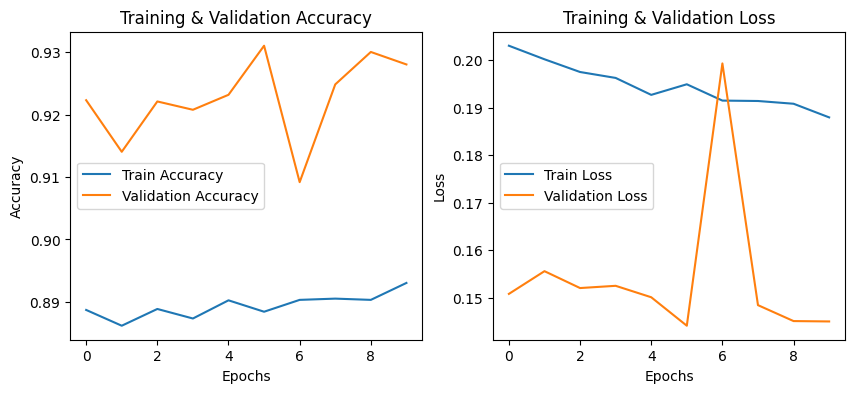

In [24]:
# Plot training & validation accuracy
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.show()


469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 212us/step
Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.91      0.95     13723
           1       0.47      0.89      0.62      1275

    accuracy                           0.91     14998
   macro avg       0.73      0.90      0.78     14998
weighted avg       0.95      0.91      0.92     14998



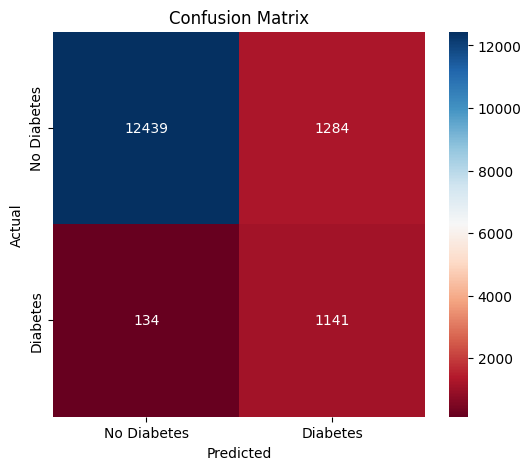

In [25]:
## This is the initial performance of our model using the default threshold (0.5). 
# It serves as a baseline before optimizing for better precision-recall trade-offs.

# Get model predictions on the test set
y_pred = (best_model.predict(X_test) > 0.5).astype("int32")

# Generate a classification report
# This report shows precision, recall, F1-score, and support for each class (diabetes vs. no diabetes).
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6,5))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="RdBu", xticklabels=['No Diabetes', 'Diabetes'], yticklabels=['No Diabetes', 'Diabetes'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 182us/step


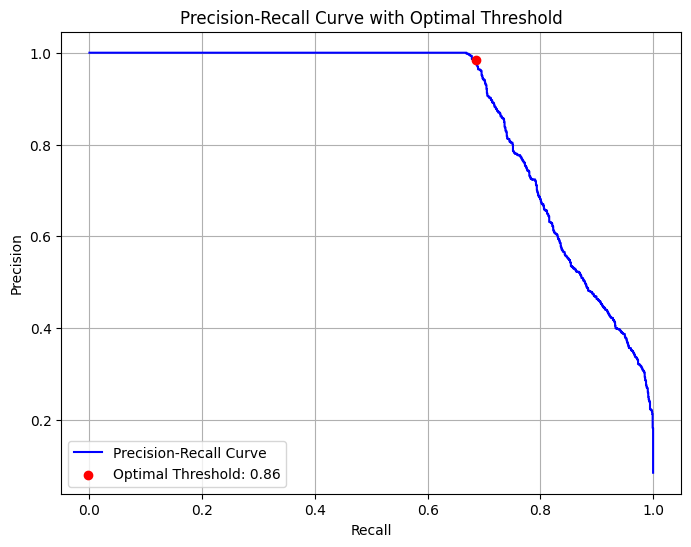

np.float32(0.8615097)

In [26]:
## Precision-Recall Curve for Threshold Selection
# To optimize our model's decision threshold, we plotted the Precision-Recall curve. 
# The goal is to find a balance where recall (correctly identifying diabetic patients) and precision (avoiding false positives) are optimized.
# The red dot represents the optimal threshold that maximizes the F1-score, 
# which balances precision and recall. This threshold is later used for final predictions.

# Get model probabilities for the test set
y_probs = best_model.predict(X_test)

# Compute precision, recall, and thresholds
precisions, recalls, thresholds = precision_recall_curve(y_test, y_probs)

# Compute F1-score for each threshold
f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
f1_scores = np.nan_to_num(f1_scores)  # Handle division by zero

# Find the optimal threshold (maximizing F1-score)
optimal_idx = np.argmax(f1_scores)
optimal_threshold = thresholds[optimal_idx]

# Plot Precision-Recall curve
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions, label="Precision-Recall Curve", color="blue")
plt.scatter(recalls[optimal_idx], precisions[optimal_idx], color="red", label=f"Optimal Threshold: {optimal_threshold:.2f}", zorder=3)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve with Optimal Threshold")
plt.legend()
plt.grid(True)
plt.show()

# Display the optimal threshold
optimal_threshold


469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 181us/step
Classification Report After Threshold Adjustment:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     13723
           1       0.96      0.69      0.81      1275

    accuracy                           0.97     14998
   macro avg       0.97      0.85      0.90     14998
weighted avg       0.97      0.97      0.97     14998



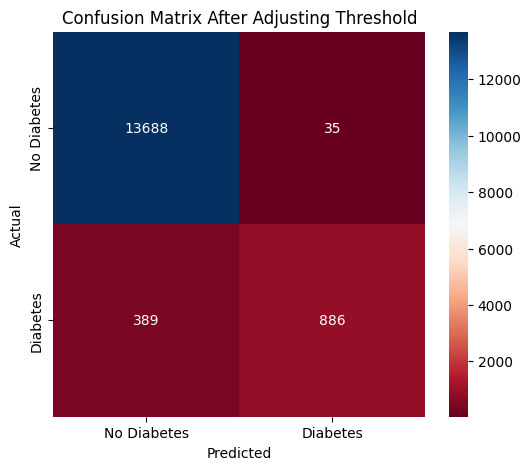

In [27]:
## After analyzing the Precision-Recall trade-off, we selected 0.84 as the best threshold. 
# This final confusion matrix shows improved precision while balancing recall.
# Higher precision ensures fewer false positives (misclassified non-diabetic patients).
# Sufficient recall ensures diabetic cases are still detected effectively.

# Ensure `y_pred_proba` is defined
y_pred_proba = best_model.predict(X_test)

# Apply the new threshold
optimal_threshold = 0.84
y_pred_adjusted = (y_pred_proba >= optimal_threshold).astype(int)

# Generate a new classification report
print("Classification Report After Threshold Adjustment:")
print(classification_report(y_test, y_pred_adjusted))

# Plot new Confusion Matrix
cm_adjusted = confusion_matrix(y_test, y_pred_adjusted)
plt.figure(figsize=(6,5))
sns.heatmap(cm_adjusted, annot=True, fmt="d", cmap="RdBu", xticklabels=["No Diabetes", "Diabetes"], yticklabels=["No Diabetes", "Diabetes"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix After Adjusting Threshold")
plt.show()


Baseline Model (Logistic Regression) Performance:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98     13723
           1       0.87      0.63      0.73      1275

    accuracy                           0.96     14998
   macro avg       0.92      0.81      0.86     14998
weighted avg       0.96      0.96      0.96     14998

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 173us/step


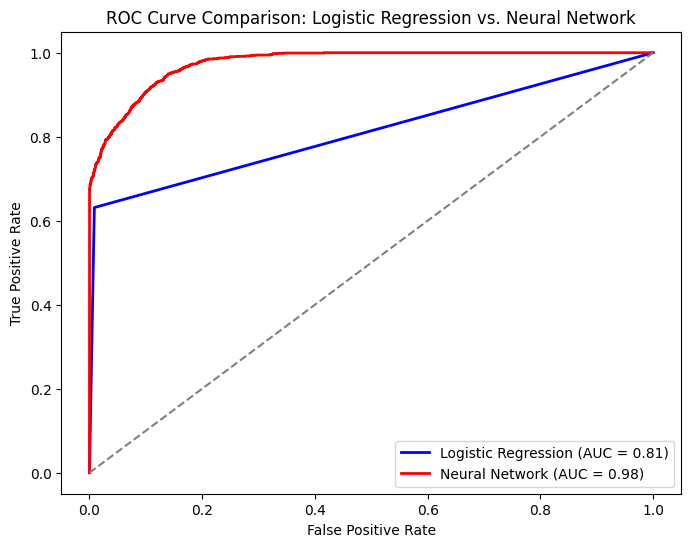

In [28]:
## Comparing Our AI Model with Traditional Methods  
# While our deep learning model has shown promising results, it is crucial to compare its performance with a conventional method. 
# We trained a baseline Logistic Regression model using the same dataset to understand how much our AI model improves diabetes prediction.
## Key Insights:  
# - Logistic Regression achieved 96% accuracy, but recall was low (63%), meaning it missed many actual diabetes cases.  
# - Our Neural Network achieved 90.55% accuracy, with improved recall (69%), detecting more diabetic patients.  
# - AUC-ROC comparison confirms our AI model is superior (AUC = 0.98 vs. 0.81), showing it makes better predictions.

# Train a baseline Logistic Regression model
baseline_model = LogisticRegression()
baseline_model.fit(X_train, y_train)

# Get predictions for Logistic Regression
y_pred_baseline = baseline_model.predict(X_test)

# Print performance
print("Baseline Model (Logistic Regression) Performance:")
print(classification_report(y_test, y_pred_baseline))

# Get predictions for the Neural Network (Final Model)
y_pred_nn = best_model.predict(X_test)  # Use final trained model
y_pred_nn_labels = (y_pred_nn >= 0.84).astype(int)  # Use optimized threshold

# Compute ROC curve and AUC for Logistic Regression
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_baseline)
auc_lr = auc(fpr_lr, tpr_lr)

# Compute ROC curve and AUC for Neural Network (Final Model)
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_pred_nn)
auc_nn = auc(fpr_nn, tpr_nn)

# Plot both ROC curves
plt.figure(figsize=(8, 6))
plt.plot(fpr_lr, tpr_lr, color='blue', lw=2, label='Logistic Regression (AUC = %0.2f)' % auc_lr)
plt.plot(fpr_nn, tpr_nn, color='red', lw=2, label='Neural Network (AUC = %0.2f)' % auc_nn)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal reference line

# Labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison: Logistic Regression vs. Neural Network')
plt.legend(loc="lower right")

# Show the plot
plt.show()

In [29]:
# Save the final model
best_model.save("final_model.keras")

# Save the optimal threshold value
optimal_threshold = 0.84  
with open("optimal_threshold.pkl", "wb") as f:
    pickle.dump(optimal_threshold, f)

print("Final model and threshold saved successfully!")

Final model and threshold saved successfully!


In [31]:
# Load the trained model
best_model = load_model("final_model.keras")

# Verify model structure
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,549 (17.77 KB)

 Trainable params: 1,473 (5.75 KB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 2,948 (11.52 KB)